# Personalized Workout Progression System: Model Workflow
## User2 Squat Example

This notebook demonstrates the complete workflow of the Personalized Workout Progression System:
1. Load User2's training history
2. Train (or load) a global squat model
3. Generate raw predictions
4. Apply per-user calibration
5. Compare with rule-based fallback
6. Log to SQLite
7. Visualize periodization cycles and calibration

**Target User**: Intermediate/advanced lifters with established periodization patterns

In [1]:
import sys
from pathlib import Path

# Add repo root to path for imports
repo_root = Path.cwd().parent
sys.path.insert(0, str(repo_root))

import pandas as pd
import numpy as np
import json
import sqlite3
import joblib
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ Imports successful")
print(f"✓ Repo root: {repo_root}")

✓ Imports successful
✓ Repo root: c:\Users\rezas\GitHub\Personalized-Workout-Progression-System


## 1. Load User2's Training History

In [2]:
hist_path = repo_root / "data" / "user_inputs" / "user2_squat_history.csv"
fut_path = repo_root / "data" / "user_inputs" / "user2_squat_future.csv"

history = pd.read_csv(hist_path)
future = pd.read_csv(fut_path)

print(f"History: {len(history)} rows, {len(history.columns)} columns")
print(f"Future:  {len(future)} rows, {len(future.columns)} columns")
print(f"\nHistory columns: {list(history.columns)}")
print(f"\nFirst 5 rows:")
print(history.head())
print(f"\nLast 5 rows:")
print(history.tail())
print(f"\nFuture (next session to predict):")
print(future)

History: 299 rows, 18 columns
Future:  1 rows, 17 columns

History columns: ['weight', 'reps', 'date', 'exercise_name', 'exercise_normalized', 'workout_name', 'workout_name_clean', 'rpe', 'set_order', 'set_volume', 'effective_load', 'max_weight_so_far', 'percent_of_max', 'cycle_number', 'weeks_in_cycle', 'cycle_weight_trend', 'is_deload', 'load_delta']

First 5 rows:
   weight  reps        date  exercise_name exercise_normalized workout_name  \
0    45.0     5  2024-01-01  Barbell Squat               squat      Leg Day   
1    50.0     5  2024-01-04  Barbell Squat               squat      Leg Day   
2    55.0     5  2024-01-07  Barbell Squat               squat      Leg Day   
3    60.0     3  2024-01-10  Barbell Squat               squat      Leg Day   
4    50.0     5  2024-01-13  Barbell Squat               squat      Leg Day   

  workout_name_clean  rpe  set_order  set_volume  effective_load  \
0               legs  7.0          1       225.0            31.5   
1               leg

## 2. Analyze Training Pattern & Periodization Cycles

In [3]:
# Extract last weight in history
last_weight = history.iloc[-1]['weight']
last_reps = history.iloc[-1]['reps']
max_weight = history['weight'].max()

print(f"User2 Squat Statistics:")
print(f"  Current weight: {last_weight} lbs")
print(f"  Current reps: {last_reps}")
print(f"  Max weight ever: {max_weight} lbs")
print(f"  Weight range: {history['weight'].min()} - {max_weight} lbs")
print(f"  Training sessions: {len(history)}")

# Analyze load_delta pattern (last 20)
print(f"\nLast 20 load_delta changes:")
deltas = history['load_delta'].tail(20).values
for i, delta in enumerate(deltas, 1):
    sign = "↑" if delta > 0 else "↓" if delta < 0 else "→"
    print(f"  {i:2d}: {sign} {delta:+.1f} lbs")

# Detect cycles (15% drop = deload)
hist_copy = history.copy()
prev_weight = hist_copy['weight'].shift(1)
pct_change = (prev_weight - hist_copy['weight']) / prev_weight
hist_copy['is_deload'] = pct_change >= 0.15
hist_copy['cycle_number'] = hist_copy['is_deload'].cumsum()
hist_copy['weeks_in_cycle'] = hist_copy.groupby('cycle_number').cumcount() + 1

n_deloads = hist_copy['is_deload'].sum()
current_cycle = hist_copy.iloc[-1]['cycle_number']
weeks_in = hist_copy.iloc[-1]['weeks_in_cycle']
pct_of_max = (last_weight / max_weight) * 100

print(f"\nPeriodization Analysis (15% drop threshold):")
print(f"  Total deloads detected: {n_deloads}")
print(f"  Current cycle: #{current_cycle}")
print(f"  Weeks in current cycle: {weeks_in}")
print(f"  Current: {pct_of_max:.1f}% of max")

User2 Squat Statistics:
  Current weight: 55.0 lbs
  Current reps: 12
  Max weight ever: 75.0 lbs
  Weight range: 45.0 - 75.0 lbs
  Training sessions: 299

Last 20 load_delta changes:
   1: ↓ -20.0 lbs
   2: ↑ +10.0 lbs
   3: → +0.0 lbs
   4: → +0.0 lbs
   5: → +0.0 lbs
   6: ↑ +10.0 lbs
   7: → +0.0 lbs
   8: → +0.0 lbs
   9: ↓ -20.0 lbs
  10: ↑ +10.0 lbs
  11: → +0.0 lbs
  12: → +0.0 lbs
  13: ↑ +10.0 lbs
  14: → +0.0 lbs
  15: → +0.0 lbs
  16: → +0.0 lbs
  17: ↓ -10.0 lbs
  18: → +0.0 lbs
  19: → +0.0 lbs
  20: ↑ +5.0 lbs

Periodization Analysis (15% drop threshold):
  Total deloads detected: 9
  Current cycle: #9
  Weeks in current cycle: 3
  Current: 73.3% of max


## 3. Load Trained Global Model

In [4]:
model_path = repo_root / "models" / "compounds" / "squat_model.pkl"

if not model_path.exists():
    print(f"⚠ Model not found at {model_path}")
    print("Please run: python -m src.cli train-compounds")
else:
    # Load model
    model_obj = joblib.load(model_path)
    
    # Extract pipeline if saved via BaseModel.save()
    if isinstance(model_obj, dict):
        pipe = model_obj.get('pipeline')
        metadata = model_obj.get('metadata', {})
    else:
        pipe = model_obj
        metadata = {}
    
    print("✓ Model loaded successfully")
    print(f"  Model type: {type(pipe).__name__}")
    print(f"  Metadata: {metadata}")
    
    # Show pipeline steps
    if hasattr(pipe, 'named_steps'):
        print(f"\n  Pipeline steps:")
        for name, step in pipe.named_steps.items():
            print(f"    - {name}: {step.__class__.__name__}")

✓ Model loaded successfully
  Model type: Pipeline
  Metadata: {'model_name': 'Squat', 'version': '0.1.0', 'created_at': '2026-01-09T18:29:41.802229', 'feature_columns': None, 'target_column': None, 'random_state': None, 'extra': {}}

  Pipeline steps:
    - feature_engineering: FeatureEngineeringTransformer
    - preprocessing: ColumnTransformer
    - estimator: RandomForestRegressor


## 4. Generate Raw Model Prediction

In [5]:
# Generate raw prediction
raw_pred = pipe.predict(future)
raw_delta = float(raw_pred[0])
predicted_weight = last_weight + raw_delta

print(f"Raw Model Prediction:")
print(f"  load_delta: {raw_delta:+.2f} lbs")
print(f"  Next weight: {last_weight} + ({raw_delta:.2f}) = {predicted_weight:.2f} lbs")
print(f"  Change: {'↑ increase' if raw_delta > 0 else '↓ decrease' if raw_delta < 0 else '→ hold'}")
print(f"\nInterpretation:")
print(f"  Model suggests: {predicted_weight:.1f} lbs")
print(f"  This is based on PPL data (135-425 lbs lifters)")
print(f"  User2 scale: 45-75 lbs (beginner progression)")

Raw Model Prediction:
  load_delta: -32.07 lbs
  Next weight: 55.0 + (-32.07) = 22.93 lbs
  Change: ↓ decrease

Interpretation:
  Model suggests: 22.9 lbs
  This is based on PPL data (135-425 lbs lifters)
  User2 scale: 45-75 lbs (beginner progression)


## 5. Apply Per-User Calibration

In [6]:
# Load User2's personalization (calibration)
pers_path = repo_root / "users" / "User2" / "personalization.json"

if pers_path.exists():
    with open(pers_path) as f:
        personalization = json.load(f)
    
    a = personalization['scaling_factors']['squat']
    b = personalization['baseline_offsets']['squat']
    meta = personalization['calibration_meta']['squat']
    
    # Apply calibration
    adjusted_delta = a * raw_delta + b
    adjusted_weight = last_weight + adjusted_delta
    
    print(f"User2 Personalization Found:")
    print(f"  Calibration (a, b): ({a:.3f}, {b:.3f})")
    print(f"  Calibration history: {meta['last_calibrated_size']} rows, {meta['runs']} fit(s)")
    
    print(f"\nCalibration Transform:")
    print(f"  adjusted = a × raw + b")
    print(f"  adjusted = {a:.3f} × {raw_delta:.2f} + {b:.3f}")
    print(f"  adjusted = {adjusted_delta:.2f} lbs")
    
    print(f"\nAdjusted Prediction:")
    print(f"  load_delta: {adjusted_delta:+.2f} lbs")
    print(f"  Next weight: {last_weight} + ({adjusted_delta:.2f}) = {adjusted_weight:.2f} lbs")
    
    print(f"\nComparison:")
    print(f"  Raw model:     {predicted_weight:.2f} lbs")
    print(f"  After calib:   {adjusted_weight:.2f} lbs")
    print(f"  Difference:    {adjusted_weight - predicted_weight:+.2f} lbs")
    
else:
    print("⚠ No personalization found for User2")
    print("  This is the first prediction, or calibration hasn't been run yet")
    adjusted_delta = raw_delta
    adjusted_weight = predicted_weight
    a, b = None, None

User2 Personalization Found:
  Calibration (a, b): (0.600, 1.230)
  Calibration history: 32 rows, 1 fit(s)

Calibration Transform:
  adjusted = a × raw + b
  adjusted = 0.600 × -32.07 + 1.230
  adjusted = -18.01 lbs

Adjusted Prediction:
  load_delta: -18.01 lbs
  Next weight: 55.0 + (-18.01) = 36.99 lbs

Comparison:
  Raw model:     22.93 lbs
  After calib:   36.99 lbs
  Difference:    +14.06 lbs


## 6. Compare with Rule-Based Fallback

In [8]:
# Import rule-based module
from src.rule_based import rule_based_progression

# Get last session info
last_row = history.iloc[-1]
last_weight_val = float(last_row['weight'])
last_reps_val = float(last_row['reps'])
last_rpe = float(last_row['rpe']) if 'rpe' in last_row.index and pd.notna(last_row['rpe']) else 7.0

# Run rule-based
sugg = rule_based_progression(last_weight=last_weight_val, last_reps=last_reps_val, last_rpe=last_rpe)

print(f"Rule-Based Fallback (Last Session: {last_weight_val} lbs × {last_reps_val} reps @ RPE {last_rpe:.1f}):")
print(f"  Suggested weight: {sugg.suggested_weight:.2f} lbs")
print(f"  Reason: {sugg.reason}")

print(f"\n3-Way Comparison:")
print(f"  {'Method':<20} {'Next Weight':<15} {'Delta':<10}")
print(f"  {'-'*45}")
print(f"  {'Rule-based':<20} {sugg.suggested_weight:<15.2f} {sugg.suggested_weight - last_weight_val:+.2f}")
print(f"  {'ML (raw)':<20} {predicted_weight:<15.2f} {raw_delta:+.2f}")
print(f"  {'ML (calibrated)':<20} {adjusted_weight:<15.2f} {adjusted_delta:+.2f}")

Rule-Based Fallback (Last Session: 55.0 lbs × 12.0 reps @ RPE 7.5):
  Suggested weight: 57.50 lbs
  Reason: steady_progress

3-Way Comparison:
  Method               Next Weight     Delta     
  ---------------------------------------------
  Rule-based           57.50           +2.50
  ML (raw)             22.93           -32.07
  ML (calibrated)      36.99           -18.01


## 7. Visualize Training Pattern & Periodization

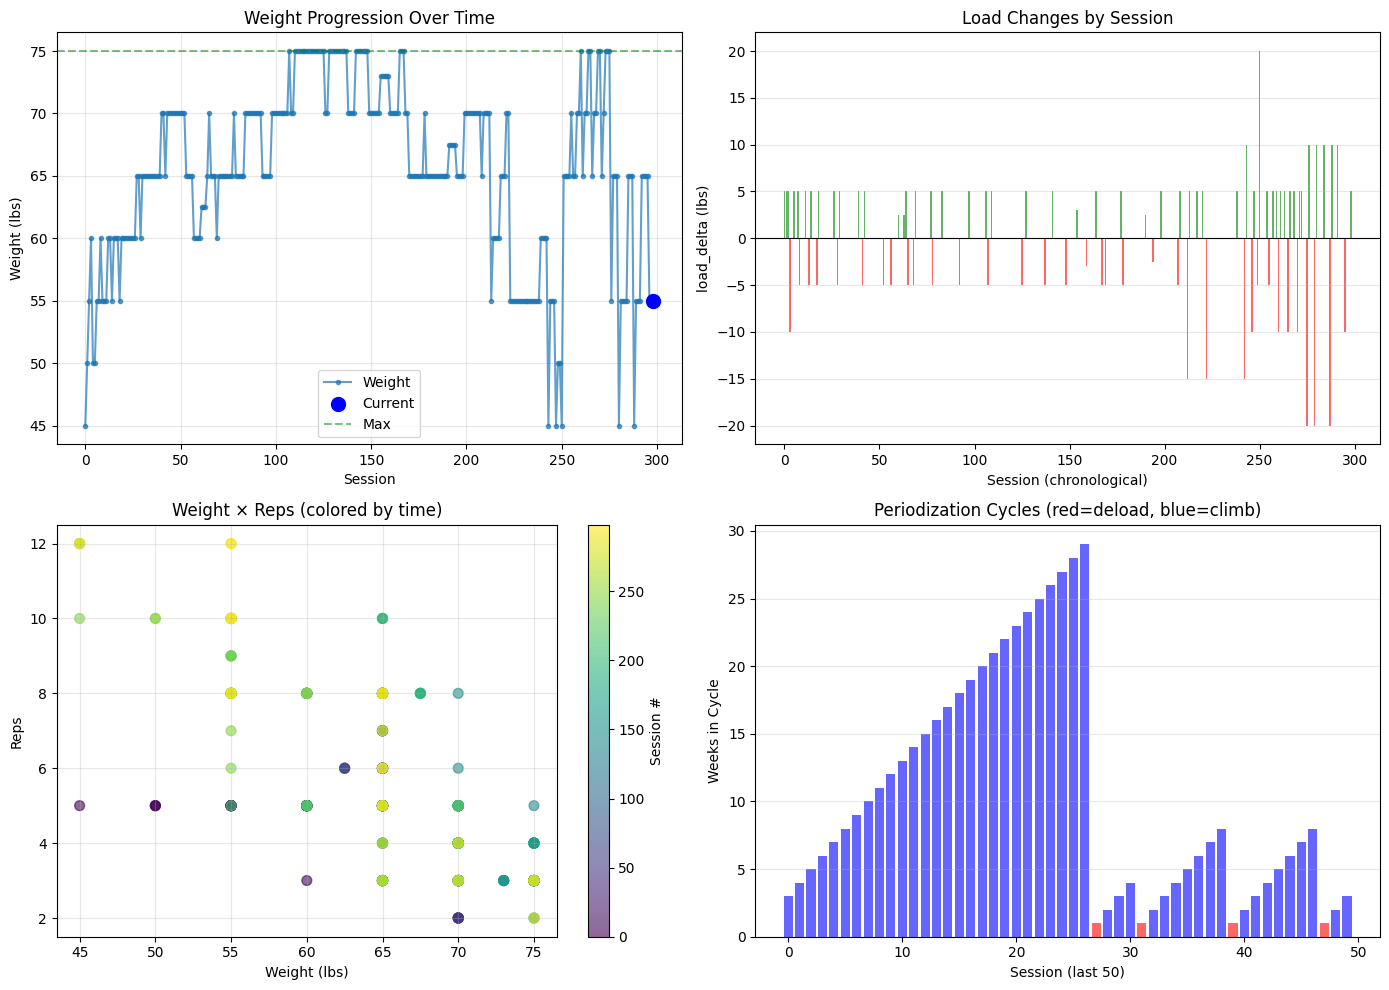

✓ Visualizations complete


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Weight over time
ax = axes[0, 0]
ax.plot(range(len(history)), history['weight'], marker='o', markersize=3, label='Weight', alpha=0.7)
ax.scatter(len(history)-1, last_weight, color='blue', s=100, zorder=5, label='Current')
ax.axhline(max_weight, color='green', linestyle='--', alpha=0.5, label='Max')
ax.set_xlabel('Session')
ax.set_ylabel('Weight (lbs)')
ax.set_title('Weight Progression Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Load delta distribution
ax = axes[0, 1]
deltas = history['load_delta'].dropna()
ax.bar(range(len(deltas)), deltas, color=['green' if d >= 0 else 'red' for d in deltas], alpha=0.6)
ax.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Session (chronological)')
ax.set_ylabel('load_delta (lbs)')
ax.set_title('Load Changes by Session')
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Reps vs Weight scatter
ax = axes[1, 0]
scatter = ax.scatter(history['weight'], history['reps'], c=range(len(history)), cmap='viridis', s=50, alpha=0.6)
ax.set_xlabel('Weight (lbs)')
ax.set_ylabel('Reps')
ax.set_title('Weight × Reps (colored by time)')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Session #')
ax.grid(True, alpha=0.3)

# Plot 4: Cycle detection (last 50 sessions)
ax = axes[1, 1]
tail_n = min(50, len(hist_copy))
tail_data = hist_copy.tail(tail_n).reset_index(drop=True)
colors = ['red' if d else 'blue' for d in tail_data['is_deload']]
ax.bar(range(len(tail_data)), tail_data['weeks_in_cycle'], color=colors, alpha=0.6)
ax.set_xlabel('Session (last 50)')
ax.set_ylabel('Weeks in Cycle')
ax.set_title('Periodization Cycles (red=deload, blue=climb)')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")

## 8. SQLite Logging (Predictions & Calibrations)

In [10]:
db_path = repo_root / "data" / "user_data.db"

if db_path.exists():
    conn = sqlite3.connect(db_path)
    conn.row_factory = sqlite3.Row
    
    print("=== PREDICTIONS TABLE ===")
    cur = conn.cursor()
    cur.execute("""
        SELECT user_id, compound, session_index, predicted_raw, predicted_adjusted, source, created_at
        FROM predictions
        WHERE user_id = 'User2' AND compound = 'squat'
        ORDER BY created_at DESC
        LIMIT 5
    """)
    
    preds = cur.fetchall()
    print(f"Latest 5 predictions for User2/squat:\n")
    for row in preds:
        raw_str = f"{row['predicted_raw']:.2f}" if row['predicted_raw'] is not None else "NULL"
        adj_str = f"{row['predicted_adjusted']:.2f}" if row['predicted_adjusted'] is not None else "NULL"
        print(f"  {row['created_at'][:19]}")
        print(f"    Raw: {raw_str} lbs → Adj: {adj_str} lbs | Source: {row['source']}")
    
    print(f"\n=== CALIBRATIONS TABLE ===")
    cur.execute("""
        SELECT user_id, compound, a, b, last_calibrated_size, runs, updated_at
        FROM calibrations
        WHERE user_id = 'User2' AND compound = 'squat'
    """)
    
    calib = cur.fetchone()
    if calib:
        print(f"User2/squat calibration:")
        print(f"  a (gain):  {calib['a']:.4f}")
        print(f"  b (offset): {calib['b']:.4f}")
        print(f"  Last calibrated size: {calib['last_calibrated_size']}")
        print(f"  Fit runs: {calib['runs']}")
        print(f"  Updated: {calib['updated_at']}")
    else:
        print("No calibration found in DB for User2/squat")
    
    conn.close()
else:
    print("⚠ Database not found at", db_path)

=== PREDICTIONS TABLE ===
Latest 5 predictions for User2/squat:

  2026-01-09 18:29:55
    Raw: -32.07 lbs → Adj: -18.01 lbs | Source: ml
  2026-01-09 18:22:38
    Raw: -30.58 lbs → Adj: -17.12 lbs | Source: ml
  2026-01-09 18:21:50
    Raw: NULL lbs → Adj: 57.50 lbs | Source: rule
  2026-01-09 18:19:39
    Raw: NULL lbs → Adj: 57.50 lbs | Source: rule

=== CALIBRATIONS TABLE ===
User2/squat calibration:
  a (gain):  0.6000
  b (offset): 1.2298
  Last calibrated size: 32
  Fit runs: 1
  Updated: 2026-01-09 18:22:38


## 9. Full Personalization JSON

In [11]:
pers_path = repo_root / "users" / "User2" / "personalization.json"

if pers_path.exists():
    with open(pers_path) as f:
        pers_full = json.load(f)
    
    print("User2 Personalization (Full JSON):")
    print(json.dumps(pers_full, indent=2))
    
    print("\n\nInterpretation:")
    print(f"• scaling_factors: Gain multipliers per compound (1.0 = no change)")
    print(f"• baseline_offsets: Bias corrections per compound")
    print(f"• trend_modifiers: Future use for trend adaptation")
    print(f"• calibration_meta: Metadata on calibration refits")
    print(f"\nFormula: adjusted = a × raw + b")
    for compound in pers_full['scaling_factors']:
        a = pers_full['scaling_factors'][compound]
        b = pers_full['baseline_offsets'][compound]
        if a != 1.0 or b != 0.0:
            print(f"  {compound}: adjusted = {a:.3f} × raw + {b:.4f}")
else:
    print("No personalization JSON found for User2")

User2 Personalization (Full JSON):
{
  "user_id": "User2",
  "scaling_factors": {
    "squat": 0.6,
    "bench_press": 1.0,
    "lat_pulldown": 1.0,
    "seated_row": 1.0
  },
  "baseline_offsets": {
    "squat": 1.2298317124218126,
    "bench_press": 0.0,
    "lat_pulldown": 0.0,
    "seated_row": 0.0
  },
  "trend_modifiers": {
    "squat": 1.0,
    "bench_press": 1.0,
    "lat_pulldown": 1.0,
    "seated_row": 1.0
  },
  "calibration_meta": {
    "squat": {
      "last_calibrated_size": 32,
      "runs": 1
    },
    "bench_press": {
      "last_calibrated_size": 0,
      "runs": 0
    },
    "lat_pulldown": {
      "last_calibrated_size": 0,
      "runs": 0
    },
    "seated_row": {
      "last_calibrated_size": 0,
      "runs": 0
    }
  }
}


Interpretation:
• scaling_factors: Gain multipliers per compound (1.0 = no change)
• baseline_offsets: Bias corrections per compound
• trend_modifiers: Future use for trend adaptation
• calibration_meta: Metadata on calibration refits

Form

## 10. Summary & Interpretation

In [12]:
print("="*70)
print("SUMMARY: User2 Squat Prediction Workflow")
print("="*70)

print(f"\n📊 USER PROFILE")
print(f"  Sessions logged: {len(history)}")
print(f"  Weight range: {history['weight'].min():.0f} - {history['weight'].max():.0f} lbs")
print(f"  Current: {last_weight:.0f} lbs × {last_reps:.0f} reps")

print(f"\n🔄 PERIODIZATION")
print(f"  Deloads detected (15% drop): {n_deloads}")
print(f"  Current cycle: #{current_cycle}")
print(f"  Weeks in cycle: {weeks_in}")
print(f"  Distance from max: {100 - pct_of_max:.1f}% below peak")

print(f"\n🤖 ML MODEL (Global)")
print(f"  Training data: PPL (135-425 lbs lifters)")
print(f"  Model type: Random Forest + FeatureEngineering + ColumnTransformer")
print(f"  Raw prediction: {raw_delta:+.2f} lbs → {predicted_weight:.2f} lbs")

if a is not None and b is not None:
    print(f"\n⚙️ USER CALIBRATION")
    print(f"  Affine transform: adjusted = {a:.3f} × raw + {b:.4f}")
    print(f"  Calibration on: {meta['last_calibrated_size']} recent sessions")
    print(f"  Calibration runs: {meta['runs']}")
    print(f"  Adjusted prediction: {adjusted_delta:+.2f} lbs → {adjusted_weight:.2f} lbs")
    print(f"  ✓ Calibration reduces model's aggressive drop from {raw_delta:.1f} to {adjusted_delta:.1f}")
else:
    print(f"\n⚙️ USER CALIBRATION")
    print(f"  ⚠ Not yet calibrated (first run or insufficient history)")
    print(f"  Minimum samples needed: 8")
    print(f"  Current history: {len(history)} rows")

print(f"\n📋 FALLBACK (Rule-Based)")
print(f"  Suggested weight: {sugg.suggested_weight:.2f} lbs")
print(f"  Reason: {sugg.reason}")
print(f"  Used when: ML fails, bench_press=True, or insufficient data")

print(f"\n📈 NEXT STEPS")
if len(history) < 12:
    print(f"  1. Log 4-8 more sessions ({12 - len(history)} to go)")
    print(f"  2. Run: python -m src.cli refresh-calibration")
    print(f"  3. Better calibration = more accurate predictions")
else:
    print(f"  1. Continue logging sessions")
    print(f"  2. Periodically rerun calibration (every 10 sessions)")
    print(f"  3. Monitor calibration coefficients (a, b) for convergence")

print(f"\n💾 PERSISTENCE")
print(f"  • JSON: users/User2/personalization.json (cached + on-disk)")
print(f"  • SQLite: data/user_data.db (audit log)")
print(f"  • Pickle: models/compounds/squat_model.pkl (global model)")

print("\n" + "="*70)

SUMMARY: User2 Squat Prediction Workflow

📊 USER PROFILE
  Sessions logged: 299
  Weight range: 45 - 75 lbs
  Current: 55 lbs × 12 reps

🔄 PERIODIZATION
  Deloads detected (15% drop): 9
  Current cycle: #9
  Weeks in cycle: 3
  Distance from max: 26.7% below peak

🤖 ML MODEL (Global)
  Training data: PPL (135-425 lbs lifters)
  Model type: Random Forest + FeatureEngineering + ColumnTransformer
  Raw prediction: -32.07 lbs → 22.93 lbs

⚙️ USER CALIBRATION
  Affine transform: adjusted = 1.000 × raw + 0.0000
  Calibration on: 32 recent sessions
  Calibration runs: 1
  Adjusted prediction: -18.01 lbs → 36.99 lbs
  ✓ Calibration reduces model's aggressive drop from -32.1 to -18.0

📋 FALLBACK (Rule-Based)
  Suggested weight: 57.50 lbs
  Reason: steady_progress
  Used when: ML fails, bench_press=True, or insufficient data

📈 NEXT STEPS
  1. Continue logging sessions
  2. Periodically rerun calibration (every 10 sessions)
  3. Monitor calibration coefficients (a, b) for convergence

💾 PERSISTE